In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn import preprocessing


### handle 資料


In [39]:

# Load the CSV file into a DataFrame
orig_df = pd.read_csv('ds_clean/ds_clean.csv')
orig_df

,LocationCode,DateTime,WindSpeed(m/s),Pressure(hpa),Temperature(°C),Humidity(%),Sunlight(Lux),Power(mW)
0,10,2024-03-01 17:14:06,0.0,1017.48,15.59,94.30,652.92,0.12
1,10,2024-03-01 17:14:47,0.0,1017.48,15.66,94.04,682.50,0.12
2,10,2024-03-01 17:15:47,0.0,1017.47,15.74,94.10,750.00,0.14
3,10,2024-03-01 17:16:47,0.0,1017.46,15.78,94.09,738.33,0.14
4,10,2024-03-01 17:17:47,0.0,1017.49,15.80,94.08,660.83,0.12
...,...,...,...,...,...,...,...,...
1194888,9,2024-07-23 15:50:57,0.0,994.54,30.69,72.91,2288.33,1.10
1194889,9,2024-07-23 15:51:57,0.0,994.40,30.27,73.16,3236.67,1.92
1194890,9,2024-07-23 15:52:57,0.0,994.39,29.90,72.51,4526.67,3.57
1194891,9,2024-07-23 15:53:57,0.0,994.40,29.38,73.23,4231.67,3.13


#### 把資料的時間改成從某點開始算的方式

In [16]:
# Convert the 'DateTime' column to datetime format
df = orig_df.copy()
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Extract the date part and calculate the day of the year
df['DayOfYear'] = df['DateTime'].dt.dayofyear
# Calculate the number of minutes since the start of the day
df['MinutesSinceStartOfDay'] = df['DateTime'].dt.hour * 60 + df['DateTime'].dt.minute
# Display the updated DataFrame
df = df.drop(columns=['DateTime'])
df


,LocationCode,WindSpeed(m/s),Pressure(hpa),Temperature(°C),Humidity(%),Sunlight(Lux),Power(mW),DayOfYear,MinutesSinceStartOfDay
0,10,0.0,1017.48,15.59,94.30,652.92,0.12,61,1034
1,10,0.0,1017.48,15.66,94.04,682.50,0.12,61,1034
2,10,0.0,1017.47,15.74,94.10,750.00,0.14,61,1035
3,10,0.0,1017.46,15.78,94.09,738.33,0.14,61,1036
4,10,0.0,1017.49,15.80,94.08,660.83,0.12,61,1037
...,...,...,...,...,...,...,...,...,...
1194888,9,0.0,994.54,30.69,72.91,2288.33,1.10,205,950
1194889,9,0.0,994.40,30.27,73.16,3236.67,1.92,205,951
1194890,9,0.0,994.39,29.90,72.51,4526.67,3.57,205,952
1194891,9,0.0,994.40,29.38,73.23,4231.67,3.13,205,953


In [17]:
unique_day_minute_combinations = df[['DayOfYear', 'MinutesSinceStartOfDay']].drop_duplicates()
num_unique_combinations = unique_day_minute_combinations.shape[0]
print(f"Number of unique (day, minute) combinations: {num_unique_combinations}")
# Number of unique (day, minute) combinations: 135606

Number of unique (day, minute) combinations: 167998


In [18]:
for i in range(1, 17):
    print(f"L{i} shape = {df[df["LocationCode"] == i].shape[0]}")

L1 shape = 95913
L2 shape = 81320
L3 shape = 49620
L4 shape = 51140
L5 shape = 49397
L6 shape = 46799
L7 shape = 37758
L8 shape = 111239
L9 shape = 83852
L10 shape = 85580
L11 shape = 51208
L12 shape = 77151
L13 shape = 63746
L14 shape = 60391
L15 shape = 79480
L16 shape = 77497


### 評估資料缺失狀況



In [19]:
# 複製一份 unique_day_minute_combinations 叫做 missing
missing = unique_day_minute_combinations.copy()

# 將 df 過濾為只包含必要的行
filtered_df = df[df['LocationCode'].isin([1, 2, 3])]

# 透過 groupby 聚合來檢查每組 (DayOfYear, MinutesSinceStartOfDay) 是否涵蓋所有 location
location_check = (
    filtered_df.groupby(['DayOfYear', 'MinutesSinceStartOfDay'])['LocationCode']
    .nunique()
    .reset_index()
)

# 篩選出 location 不完整的 (DayOfYear, MinutesSinceStartOfDay)
incomplete_combinations = location_check[location_check['LocationCode'] < 3]
incomplete_combinations = incomplete_combinations[['DayOfYear', 'MinutesSinceStartOfDay']]

# 將 missing 限制為不完整的組合
missing = missing.merge(incomplete_combinations, on=['DayOfYear', 'MinutesSinceStartOfDay'], how='inner')

# 顯示結果
missing


,DayOfYear,MinutesSinceStartOfDay
0,61,1034
1,61,1035
2,61,1036
3,61,1037
4,61,1038
...,...,...
118402,155,293
118403,155,294
118404,156,1129
118405,170,1137


### 評估location間的關聯性

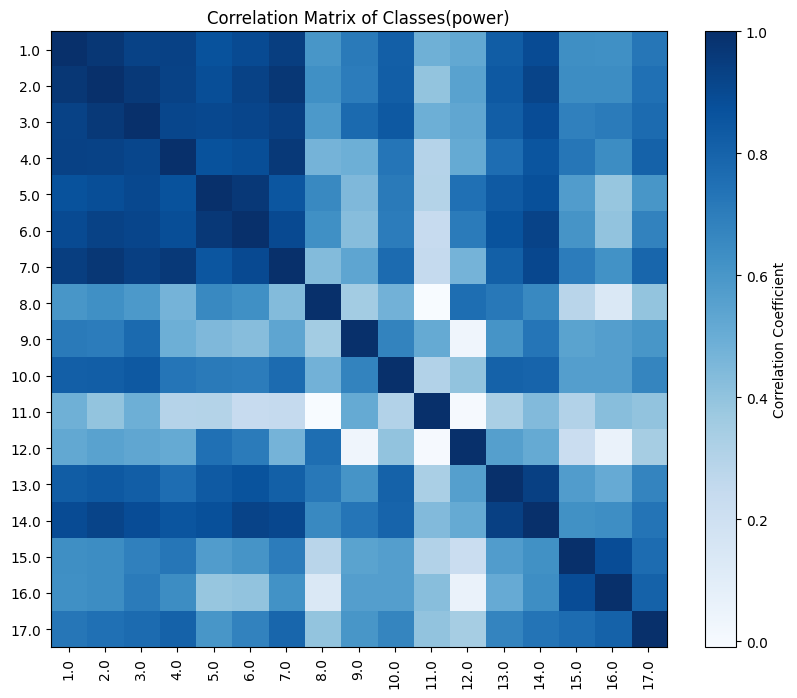

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 假設原始數據
data = df[['LocationCode', 'DayOfYear', 'MinutesSinceStartOfDay', 'Power(mW)']]

# 建立 DataFrame
class_data = pd.DataFrame(data)

# Step 1: 建立統一時間戳記欄位
class_data['timestamp'] = class_data['DayOfYear'] * 24 * 60 + class_data['MinutesSinceStartOfDay']  # 轉換成分鐘為基準的時間戳
class_data = class_data[['LocationCode', 'timestamp', 'Power(mW)']]  # 保留需要的欄位

# Step 2: 建立完整時間範圍並對齊
full_time_range = pd.DataFrame({'timestamp': np.arange(class_data['timestamp'].min(), class_data['timestamp'].max() + 1)})
merged = full_time_range.merge(class_data, on='timestamp', how='left')

# 將不同的 class 分成獨立欄位
pivot_table = merged.pivot_table(index='timestamp', columns='LocationCode', values='Power(mW)')

# Step 3: 計算相關性
correlation_matrix = pivot_table.corr(method='pearson')

# Step 4: 視覺化相關性
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='Blues', interpolation='none')
plt.colorbar(label='Correlation Coefficient')
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.index)), correlation_matrix.index)
plt.title('Correlation Matrix of Classes(power)')
plt.show()


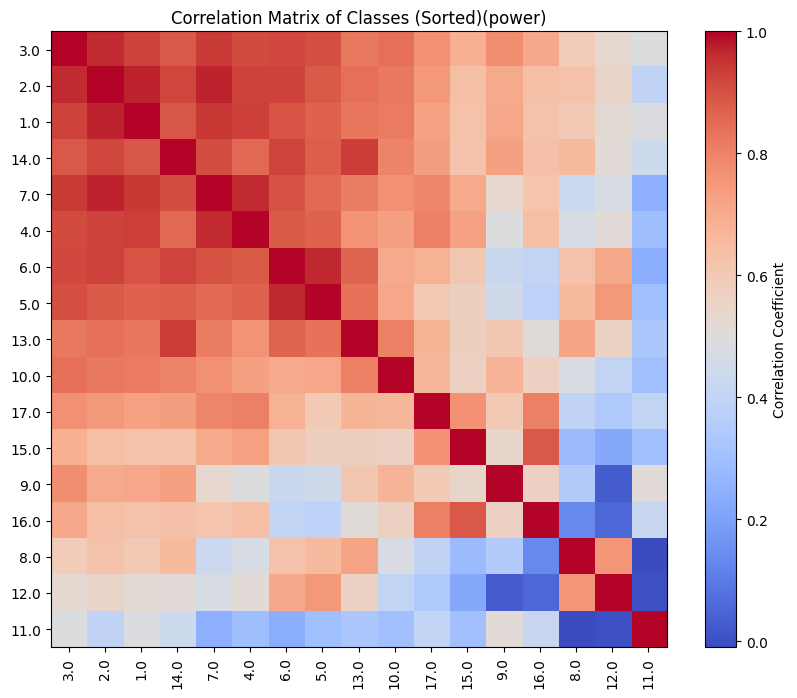

In [21]:
# Step 4: 根據平均相關性排序
mean_correlation = correlation_matrix.mean(axis=1).sort_values(ascending=False)
sorted_classes = mean_correlation.index
sorted_matrix = correlation_matrix.loc[sorted_classes, sorted_classes]

# Step 5: 視覺化相關性
plt.figure(figsize=(10, 8))
plt.imshow(sorted_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar(label='Correlation Coefficient')
plt.xticks(range(len(sorted_matrix.columns)), sorted_matrix.columns, rotation=90)
plt.yticks(range(len(sorted_matrix.index)), sorted_matrix.index)
plt.title('Correlation Matrix of Classes (Sorted)(power)')
plt.show()


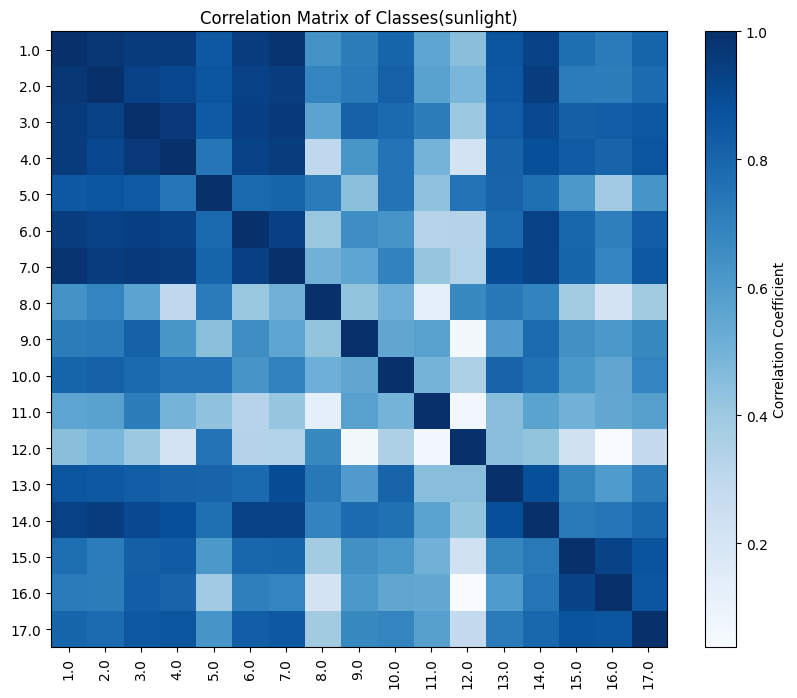

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 假設原始數據
data = df[['LocationCode', 'DayOfYear', 'MinutesSinceStartOfDay', 'Sunlight(Lux)']]

# 建立 DataFrame
class_data = pd.DataFrame(data)

# Step 1: 建立統一時間戳記欄位
class_data['timestamp'] = class_data['DayOfYear'] * 24 * 60 + class_data['MinutesSinceStartOfDay']  # 轉換成分鐘為基準的時間戳
class_data = class_data[['LocationCode', 'timestamp', 'Sunlight(Lux)']]  # 保留需要的欄位

# Step 2: 建立完整時間範圍並對齊
full_time_range = pd.DataFrame({'timestamp': np.arange(class_data['timestamp'].min(), class_data['timestamp'].max() + 1)})
merged = full_time_range.merge(class_data, on='timestamp', how='left')

# 將不同的 class 分成獨立欄位
pivot_table = merged.pivot_table(index='timestamp', columns='LocationCode', values='Sunlight(Lux)')

# Step 3: 計算相關性
correlation_matrix = pivot_table.corr(method='pearson')

# Step 4: 視覺化相關性
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='Blues', interpolation='none')
plt.colorbar(label='Correlation Coefficient')
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.index)), correlation_matrix.index)
plt.title('Correlation Matrix of Classes(sunlight)')
plt.show()


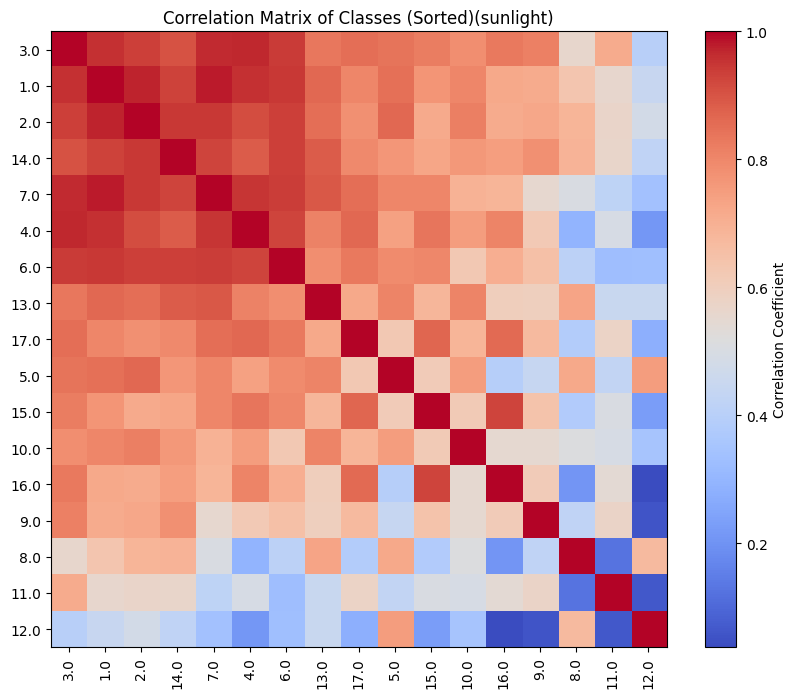

In [23]:
# Step 4: 根據平均相關性排序
mean_correlation = correlation_matrix.mean(axis=1).sort_values(ascending=False)
sorted_classes = mean_correlation.index
sorted_matrix = correlation_matrix.loc[sorted_classes, sorted_classes]

# Step 5: 視覺化相關性
plt.figure(figsize=(10, 8))
plt.imshow(sorted_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar(label='Correlation Coefficient')
plt.xticks(range(len(sorted_matrix.columns)), sorted_matrix.columns, rotation=90)
plt.yticks(range(len(sorted_matrix.index)), sorted_matrix.index)
plt.title('Correlation Matrix of Classes (Sorted)(sunlight)')
plt.show()



### 評估sunlight 跟 power 的關聯

In [24]:
# 計算每個 LocationCode 的 Power(mW) 和 Sunlight(Lux) 之間的相關性
correlations = df.groupby('LocationCode').apply(lambda x: x['Power(mW)'].corr(x['Sunlight(Lux)']))

# 顯示結果
correlations

C:\Users\meowm\AppData\Local\Temp\ipykernel_5164\1945651511.py:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



LocationCode
1     0.955955
2     0.971282
3     0.945851
4     0.922960
5     0.966143
6     0.858430
7     0.970702
8     0.948938
9     0.936156
10    0.907232
11    0.887428
12    0.887486
13    0.920463
14    0.951423
15    0.972516
16    0.964494
17    0.940716
dtype: float64

#### 策略
因為目前看起來是要找同時間的周遭測站的狀況去推估發電情形(不然就變成是猜天氣)
所以應該會需要先過濾出能train的資料
##### 目前策略
從目標時間為中心(time = t,location = l)，找t時不同location的地點，用彼此關係求值(l' -> l)
或是用(t',l)去求出->(t,l)
更甚至(t',l')->(t,l)
但因為會有資料缺失的狀況(很多t不連續)所以要先看資料周遭的狀態
去看能從哪些(t',l')來train

In [25]:
df

,LocationCode,WindSpeed(m/s),Pressure(hpa),Temperature(°C),Humidity(%),Sunlight(Lux),Power(mW),DayOfYear,MinutesSinceStartOfDay
0,10,0.0,1017.48,15.59,94.30,652.92,0.12,61,1034
1,10,0.0,1017.48,15.66,94.04,682.50,0.12,61,1034
2,10,0.0,1017.47,15.74,94.10,750.00,0.14,61,1035
3,10,0.0,1017.46,15.78,94.09,738.33,0.14,61,1036
4,10,0.0,1017.49,15.80,94.08,660.83,0.12,61,1037
...,...,...,...,...,...,...,...,...,...
1194888,9,0.0,994.54,30.69,72.91,2288.33,1.10,205,950
1194889,9,0.0,994.40,30.27,73.16,3236.67,1.92,205,951
1194890,9,0.0,994.39,29.90,72.51,4526.67,3.57,205,952
1194891,9,0.0,994.40,29.38,73.23,4231.67,3.13,205,953


In [26]:
import pandas as pd
import plotly.express as px

# 讀取數據
file_path = 'ds_clean/ds_clean.csv'
orig_df = pd.read_csv(file_path)

# 確保時間戳記格式正確
orig_df['timestamp'] = pd.to_datetime(orig_df['DateTime'])

# 計算每個 location 的時間跨度
location_time = orig_df.groupby('LocationCode')['timestamp'].agg([min, max]).reset_index()
location_time.rename(columns={'min': 'start', 'max': 'end'}, inplace=True)

# 繪製時間線圖（類似 Gantt 圖）
fig = px.timeline(
    location_time,
    x_start='start',
    x_end='end',
    y='LocationCode',
    title='Time Span of Locations',
    labels={'LocationCode': 'LocationCode'},
)

# 反轉 Y 軸，使得時間順序更直觀
fig.update_yaxes(categoryorder='total ascending')

# 顯示圖表
fig.show()


C:\Users\meowm\AppData\Local\Temp\ipykernel_5164\1036414939.py:12: FutureWarning:

The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.

C:\Users\meowm\AppData\Local\Temp\ipykernel_5164\1036414939.py:12: FutureWarning:

The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.



LocationCode	DateTime	WindSpeed(m/s)	Pressure(hpa)	Temperature(°C)	Humidity(%)	Sunlight(Lux)	Power(mW)


每日時間摘要已儲存至 daily_time_summary.csv



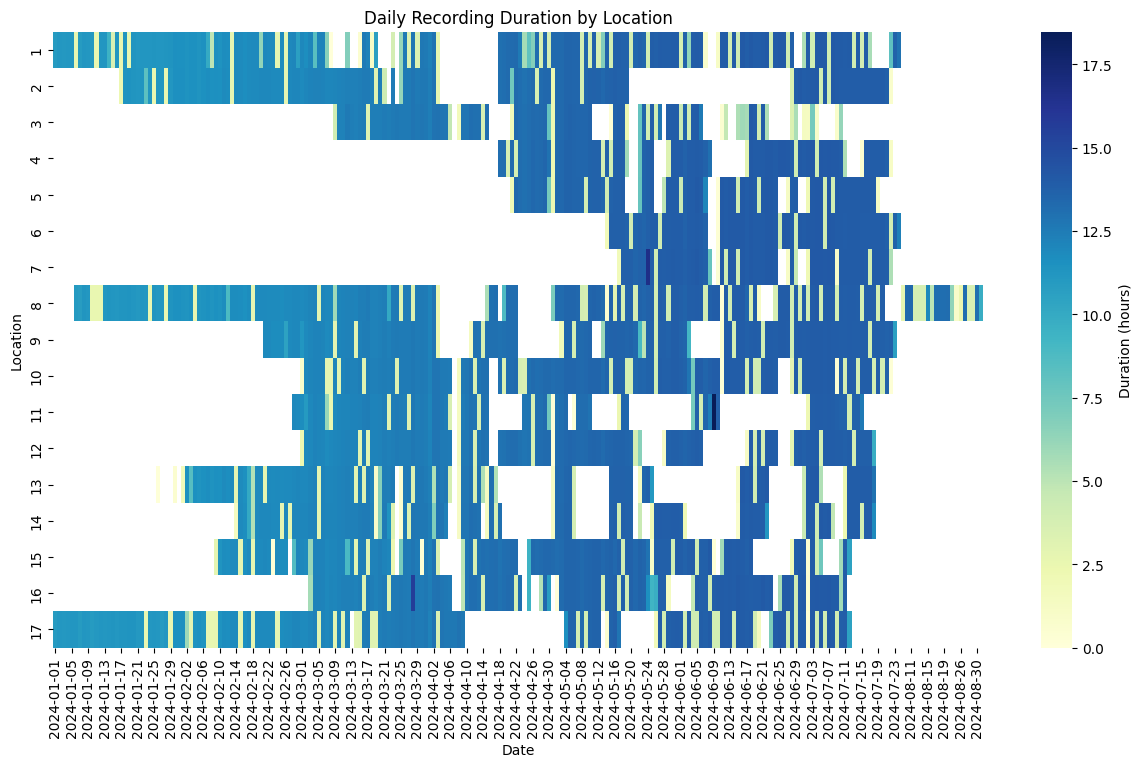

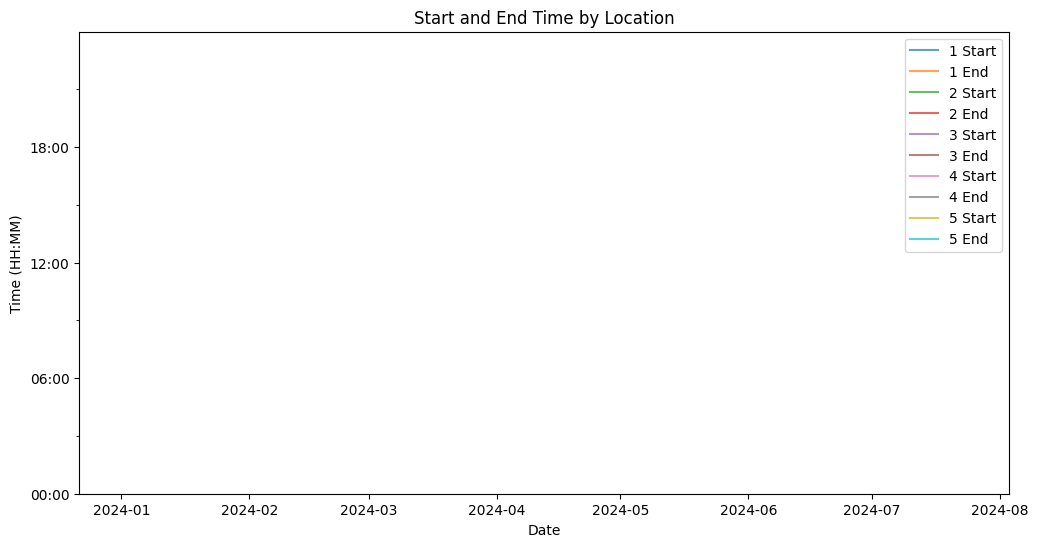

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter, HourLocator, MinuteLocator
import matplotlib.dates as mdates

file_path = 'ds_clean/ds_clean.csv'

df = pd.read_csv(file_path)
df['DateTime'] = pd.to_datetime(df['DateTime'])

# 提取日期欄位
df['date'] = df['DateTime'].dt.date

# 按 location 和日期分組，計算每天的開始和停止時間
daily_time_summary = df.groupby(['LocationCode', 'date']).agg(
    start_time=('DateTime', 'min'),
    end_time=('DateTime', 'max')
).reset_index()

# Step 2: 儲存整理好的每日紀錄時間摘要
output_path = 'daily_time_summary.csv'
daily_time_summary.to_csv(output_path, index=False)
print(f"\n每日時間摘要已儲存至 {output_path}\n")

# Step 3: 計算每日的紀錄時間跨度
daily_time_summary['duration'] = (
    daily_time_summary['end_time'] - daily_time_summary['start_time']
).dt.total_seconds() / 3600

# Step 4: 使用熱力圖觀察紀錄時間的分布
# 將每日紀錄時間跨度整理成 pivot table
pivot_table = daily_time_summary.pivot_table(index='LocationCode', columns='date', values='duration')

# 熱力圖繪製
plt.figure(figsize=(15, 8))
sns.heatmap(pivot_table, cmap='YlGnBu', cbar_kws={'label': 'Duration (hours)'})
plt.title('Daily Recording Duration by Location')
plt.xlabel('Date')
plt.ylabel('Location')
plt.show()

# Step 5: 折線圖顯示各地點的開始與停止時間變動趨勢
plt.figure(figsize=(12, 6))
for loc in daily_time_summary['LocationCode'].unique()[:5]:  # 只取前5個地點作為示例
    loc_data = daily_time_summary[daily_time_summary['LocationCode'] == loc]
    plt.plot(loc_data['date'], loc_data['start_time'], label=f"{loc} Start", alpha=0.7)
    plt.plot(loc_data['date'], loc_data['end_time'], label=f"{loc} End", alpha=0.7)

# 限制 Y 軸的時間刻度間隔並修正格式
plt.gca().yaxis.set_major_locator(mdates.HourLocator(interval=6))  # 每6小時設置主要刻度
plt.gca().yaxis.set_minor_locator(mdates.HourLocator(interval=3))  # 每3小時設置次要刻度
plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # 格式化時間為 HH:MM
plt.gca().set_ylim(pd.Timestamp('00:00').to_pydatetime(), pd.Timestamp('23:59').to_pydatetime())  # 限定Y軸範圍

plt.xlabel('Date')
plt.ylabel('Time (HH:MM)')
plt.title('Start and End Time by Location')
plt.legend()
plt.show()
